# This notebook is mainly used now for checking Ryan's notebook (01d_epkm_from_annotated).

In [2]:
%matplotlib inline
from matplotlib_venn import venn2
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import glob
import gffutils

In [3]:
annotated_edits_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/sailor_outputs_groups_deep/combined_outputs_w_cov_info'
escore_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/window_outputs_deep/'
output_dir = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/outputs/'

In [3]:
sc_rps2_escore_file = os.path.join(
    escore_dir,
    
)
sc_rps2_file = os.path.join(
    annotated_edits_dir,
    'RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.fx.annotated'
)
sc_rps2_all_file = os.path.join(
    annotated_edits_dir,
    'RPS2-STAMP_possorted_genome_bam_MD.fx.annotated'
)
# counts_file_sc = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.cds_only.txt'
# counts_file_bulk = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_only.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20200309_kris_rnaseq_all/featurecounts/counts.cds_only.txt'
counts_file_bulk = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.cds_and_3utr.txt'
counts_file_sc = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/for_featurecounts/counts.cds_and_3utr.txt'
# counts_file = '/home/bay001/projects/kris_apobec_20200121/permanent_data/20191003_riboseq/featurecounts/counts.txt'
polysome_file = '/home/rmarina/projects/apobec/revision_riboseq_comparison/ribosome_files/Polysome_RPKM_Raw.txt'

#### ```sample_id``` is to specify which column to use for counting read alignments
- should be one of the columns in a featureCounts output.

In [4]:
# sample_id_sc = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD.bam'
# sample_id = '../Sample41_S41_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
# sample_id = '../Sample42_S42_merged.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
sample_id_bulk = 'results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'
sample_id_sc = '/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam'
# sample_id = 'results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam'

# Read in annotated edit file

In [5]:
annotated_names = ['chrom','start','end','conf','cov','strand','geneid','genename','region','overlap']

edits_sc = pd.read_csv(sc_rps2_file, sep='\t', names=annotated_names)
edits_bulk = pd.read_csv(rps2_1000_file, sep='\t', names=annotated_names)

del edits_sc['overlap']
del edits_bulk['overlap']

edits_sc.head()

,chrom,start,end,conf,cov,strand,geneid,genename,region
0,chr1,29990,29991,0.999980,"3,7",+,ENSG00000243485.2,MIR1302-11,noncoding_exon
1,chr1,30662,30663,0.950990,"1,6",+,ENSG00000243485.2,MIR1302-11,noncoding_exon
2,chr1,719860,719861,0.960596,"1,5",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon
3,chr1,720211,720212,0.868746,"1,15",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon
4,chr1,722356,722357,0.777821,"1,26",+,ENSG00000237491.4,RP11-206L10.9,noncoding_exon


# If we want to filter for conf first, this is where we do it

In [6]:
conf = 0.

def filter_edits(edits):
    print(edits.shape[0])
    edits = edits[edits['conf'] >= conf]
    print(edits.shape[0])
    return edits

edits_sc = filter_edits(edits_sc)
edits_bulk = filter_edits(edits_bulk)

411598
411598
535897
535897


In [7]:
edits_sc['region'].value_counts()

3utr                       242004
CDS                        142287
noncoding_exon               9696
5utr                         7566
proxintron500                4207
distintron500                3099
intergenic                   2661
miRNA                          77
proxnoncoding_intron500         1
Name: region, dtype: int64

# Filter for the regions we want to look at.

In [8]:
regions = ['CDS', '3utr']

def filter_regions(edits):
    edits = edits[edits['region'].isin(regions)]
    edits = edits.loc[edits.geneid.apply(lambda x: len(x.split(','))) == 1] # removing ambiguous editing events (more than one gene)
    print(edits.shape[0])
    return edits

edits_sc = filter_regions(edits_sc)
edits_bulk = filter_regions(edits_bulk)

379713
464545


# Get the number of reads that were edited (C>T conversion) summed across all genes

In [9]:
def sum_edits(edits):
    edits['edited_reads'] = edits['cov'].apply(lambda x: int(x.split(',')[0]))
    return pd.DataFrame(edits.groupby('geneid')['edited_reads'].sum())
    
edits_sc = sum_edits(edits_sc)
edits_bulk = sum_edits(edits_bulk)

edits_bulk.head()

,edited_reads
geneid,
ENSG00000000003.10,353
ENSG00000000419.8,80
ENSG00000000457.9,2
ENSG00000000460.12,66
ENSG00000001036.9,216


# Read in read counts file

In [10]:
read_counts_sc = pd.read_csv(counts_file_sc, sep='\t', index_col=0, skiprows=1)
read_counts_bulk = pd.read_csv(counts_file_bulk, sep='\t', index_col=0, skiprows=1)

read_counts_bulk.head()

,Chr,Start,End,Strand,Length,results/ABCE1-0_S1_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ABCE1-50_S8_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ApoControl-0_S7_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,results/RBFOX2-0_S6_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.noRmDup.annotated.sorted.bam,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-0_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-50_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-0_S5_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-1000_S19_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-50_S12_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,chr1,69091,70005,+,915,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,chr1;chr1;chr1,134901;137621;138533,135802;138529;139309,-;-;-,2588,0,3,0,0,0,...,3,0,0,4,1,0,0,5,5,0
ENSG00000235249,chr1;chr1,367659;368598,368594;368634,+;+,973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,chr1;chr1,621059;621099,621095;622034,-;-,973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000269831,chr1;chr1;chr1,738532;738788;739121,738618;738812;739137,-;-;-,129,0,0,0,0,2,...,0,2,2,0,0,0,0,1,0,0


In [11]:
for read_counts in [read_counts_sc, read_counts_bulk]:
    for c in read_counts.columns:
        print(c)

Chr
Start
End
Strand
Length
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-1_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-2_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-5_barcodes.tsv.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD-APOBEC_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam
/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/APOBEC-STAMP_possorted_genome_bam_MD.bam
/home/bay001

In [12]:
# read_counts = read_counts[['Length', sample_id]]


# Filter for genes that were expressed. 0-5 reads min?
# read_counts = read_counts[read_counts[sample_id] > 0]
print('approx. {} genes expressed in bulk.'.format(read_counts_bulk.shape[0]))
print('approx. {} genes expressed in single cell.'.format(read_counts_sc.shape[0]))

total_mapped_bulk = read_counts_bulk[sample_id_bulk].sum()
total_mapped_sc = read_counts_sc[sample_id_sc].sum()

print('total mapped reads (bulk): {}'.format(total_mapped_bulk))
print('total mapped reads (sc): {}'.format(total_mapped_sc))

read_counts_bulk.head()

approx. 20356 genes expressed in bulk.
approx. 20356 genes expressed in single cell.
total mapped reads (bulk): 30455026
total mapped reads (sc): 91628865


,Chr,Start,End,Strand,Length,results/ABCE1-0_S1_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ABCE1-1000_S15_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ABCE1-50_S8_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ApoControl-0_S7_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/ApoControl-1000_S21_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,...,results/RBFOX2-0_S6_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted_a0_b0_e0.01.noRmDup.annotated.sorted.bam,results/RBFOX2-1000_S20_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RBFOX2-50_S13_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-0_S4_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS2-50_S11_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-0_S5_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-1000_S19_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,results/RPS3-50_S12_L001_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,,,,,,,,,,,,,,,,,,,,
ENSG00000186092,chr1,69091,70005,+,915,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,chr1;chr1;chr1,134901;137621;138533,135802;138529;139309,-;-;-,2588,0,3,0,0,0,...,3,0,0,4,1,0,0,5,5,0
ENSG00000235249,chr1;chr1,367659;368598,368594;368634,+;+,973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,chr1;chr1,621059;621099,621095;622034,-;-,973,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000269831,chr1;chr1;chr1,738532;738788;739121,738618;738812;739137,-;-;-,129,0,0,0,0,2,...,0,2,2,0,0,0,0,1,0,0


# Convert to TPM and filter if necessary
- FredX2/3 is going to be already filtered, so the difference between our gene set and his will be larger. Let's also perform a cursory filter for expression just to make sure the difference is small.

In [13]:
min_tpm = 0.0000001 # Just use anything that's expressed, we'll filter mostly based on Fred's dataset.

def counts_to_rpkm(feature_counts_table):
    counts = feature_counts_table.ix[:,5:]
    lengths = feature_counts_table['Length']
    mapped_reads = counts.sum()
    return lengths, (counts * pow(10,9)).div(mapped_reads, axis=1).div(lengths, axis=0)

def counts_to_tpm(counts_table, skip_col=5):
    """
    simple function that converts a featureCounts pandas Dataframe
    into a TPM dataframe.
    
    :param counts_table: pandas.DataFrame() 
        either a featureCounts table (first five cols contain non-count info,
        the rest contain raw counts) or a generic counts table (use skip_col=0
        in this case)
    :return tpm: pandas.DataFrame
    """
    lengths, rpkm = counts_to_rpkm(counts_table)
    tpm = rpkm.div(rpkm.sum())*pow(10,6)
    return pd.merge(lengths, tpm, how='outer', left_index=True, right_index=True)

tpm_counts_bulk = counts_to_tpm(
    counts_table=read_counts_bulk,
)
tpm_counts_sc = counts_to_tpm(
    counts_table=read_counts_sc,
)

print("Before filtering for TPM value of {} in bulk: {}".format(min_tpm, tpm_counts_bulk.shape[0]))
print("Before filtering for TPM value of {} in sc: {}".format(min_tpm, tpm_counts_sc.shape[0]))

filtered_tpm_counts_bulk = tpm_counts_bulk[tpm_counts_bulk[sample_id_bulk]>=min_tpm]
filtered_tpm_counts_sc = tpm_counts_sc[tpm_counts_sc[sample_id_sc]>=min_tpm]

print("After filtering for TPM value of {} in bulk: {}".format(min_tpm, filtered_tpm_counts_bulk.shape[0]))
print("After filtering for TPM value of {} in sc: {}".format(min_tpm, filtered_tpm_counts_sc.shape[0]))

filtered_tpm_counts_bulk = filtered_tpm_counts_bulk[['Length', sample_id_bulk]]
filtered_tpm_counts_sc = filtered_tpm_counts_sc[['Length', sample_id_sc]]

filtered_tpm_counts_bulk.head()

Before filtering for TPM value of 1e-07 in bulk: 20356
Before filtering for TPM value of 1e-07 in sc: 20356
After filtering for TPM value of 1e-07 in bulk: 15100
After filtering for TPM value of 1e-07 in sc: 15830


/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


,Length,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam
Geneid,,
ENSG00000187634,2564,8.940309
ENSG00000188976,2737,67.651487
ENSG00000187961,2527,17.986023
ENSG00000187583,2676,0.073846
ENSG00000187642,3061,0.043039


# join the read counts with edit sums
- by "edit sums" it's not exactly 1:1 with each read, since each read will be counted multiple times for each edit found. We are, however, using mapped reads as a scaling factor. 

In [14]:
def merge_counts_and_dits(edits, filtered_tpm_counts):
    
    edits.reset_index(inplace=True)
    edits['Geneid'] = edits['geneid'].apply(lambda x: x.split('.')[0])
    edits.set_index('Geneid', inplace=True)
    read_edit_counts = pd.merge(filtered_tpm_counts, edits[['edited_reads']], how='outer', left_index=True, right_index=True)
    read_edit_counts.fillna(0, inplace=True)

    # some genes aren't included in the counts matrix but are included in our edit annotations? odd. Maybe these genes have UTRs but no CDS?
    read_edit_counts = read_edit_counts[read_edit_counts['Length']>0]
    print(read_edit_counts.shape[0])
    return read_edit_counts

read_edit_counts_bulk = merge_counts_and_dits(edits_bulk, filtered_tpm_counts_bulk)
read_edit_counts_sc = merge_counts_and_dits(edits_sc, filtered_tpm_counts_sc)
read_edit_counts_bulk.head()

15100
15830


,Length,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,edited_reads
Geneid,,,
ENSG00000000003,2091.0,112.587925,353.0
ENSG00000000419,1150.0,108.485934,80.0
ENSG00000000457,6308.0,2.203343,2.0
ENSG00000000460,4213.0,14.290454,66.0
ENSG00000000938,2437.0,0.027029,0.0


# calculate EPKM
- adding (ps)eudocount here

In [15]:
ps = 1 # min(polysome_rpkm_x3[polysome_rpkm_x3 > .0].min(axis=1).dropna())
print("(ps)eudocount value", ps)

(ps)eudocount value 1


In [16]:
# (# of Edited Counts (from SAILOR)) / ((total mapped read counts/10^6)*(Gene length/1000))

def epkm(row, total_mapped, colname):
    edit_counts = row[colname]
    return edit_counts/((total_mapped/1000000.)*(row['Length']/1000.))

# total_mapped = read_edit_counts[sample_id].sum()
print(total_mapped_bulk)
read_edit_counts_bulk['epkm'] = read_edit_counts_bulk.apply(epkm, axis=1, args=(total_mapped_bulk, 'edited_reads'))
read_edit_counts_sc['epkm'] = read_edit_counts_sc.apply(epkm, axis=1, args=(total_mapped_sc, 'edited_reads'))

read_edit_counts_bulk['epkm+ps'] = read_edit_counts_bulk['epkm'] + ps
read_edit_counts_sc['epkm+ps'] = read_edit_counts_sc['epkm'] + ps

read_edit_counts_bulk.head()

30455026


,Length,results/RPS2-1000_S18_L002_R1_001.fastqTr.sorted.STARUnmapped.out.sorted.STARAligned.out.sorted.bam,edited_reads,epkm,epkm+ps
Geneid,,,,,
ENSG00000000003,2091.0,112.587925,353.0,5.543215,6.543215
ENSG00000000419,1150.0,108.485934,80.0,2.284195,3.284195
ENSG00000000457,6308.0,2.203343,2.0,0.010411,1.010411
ENSG00000000460,4213.0,14.290454,66.0,0.514391,1.514391
ENSG00000000938,2437.0,0.027029,0.0,0.000000,1.000000


In [17]:
read_edit_counts_sc.head()

,Length,/home/bay001/projects/kris_apobec_20200121/permanent_data2/07_scRNA_groups/bam_file_groups/RPS2-STAMP_possorted_genome_bam_MD-RPS2_STAMP_Apo_filtered_lenti_common_expression_barcodes.txt.bam,edited_reads,epkm,epkm+ps
Geneid,,,,,
ENSG00000000003,2091.0,52.320687,592.0,3.089836,4.089836
ENSG00000000005,1119.0,0.013191,0.0,0.000000,1.000000
ENSG00000000419,1150.0,75.751881,372.0,3.530310,4.530310
ENSG00000000457,6308.0,1.242496,4.0,0.006920,1.006920
ENSG00000000460,4213.0,6.505977,43.0,0.111390,1.111390


In [18]:
merged = pd.merge(read_edit_counts_bulk[['epkm+ps']], read_edit_counts_sc[['epkm+ps']], how='inner', left_index=True, right_index=True)
merged.head()

,epkm+ps_x,epkm+ps_y
Geneid,,
ENSG00000000003,6.543215,4.089836
ENSG00000000419,3.284195,4.530310
ENSG00000000457,1.010411,1.006920
ENSG00000000460,1.514391,1.111390
ENSG00000001036,3.317786,1.855968


In [19]:
np.log2(merged).corr()

,epkm+ps_x,epkm+ps_y
epkm+ps_x,1.000000,0.704687
epkm+ps_y,0.704687,1.000000


# log2 poly rpkm vs log2 epkm

/projects/ps-yeolab4/software/yeolabconda3/envs/python3essential-0.0.1/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


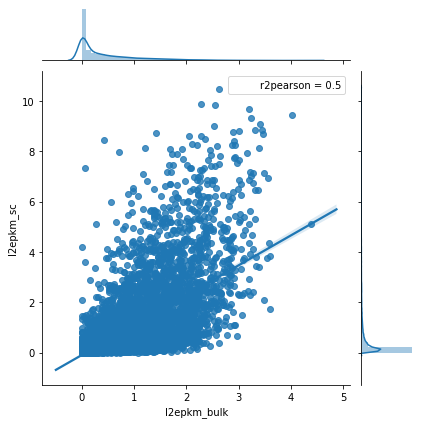

In [20]:
merged['l2epkm_bulk'] = np.log2(merged['epkm+ps_x'])
merged['l2epkm_sc'] = np.log2(merged['epkm+ps_y'])

def r2pearson(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(
    x='l2epkm_bulk',
    y='l2epkm_sc',
    data=merged,
    kind='reg',
    stat_func=r2pearson
)